# Indroduction

The project's goal is to help Zenni Optical, a well-known online eyewear retailer, provide a better service to its customers by implementing an AI-powered feature that identifies face shapes. This feature would help customers find the right glasses for their face shape more easily and accurately, improving their overall shopping experience.

In this project, I aim to recognize different face shapes using image processing and machine learning techniques. I will use a dataset containing images of four face shapes: oval, round, square, and heart. I use the OpenCV library to detect and crop faces from the images and apply edge detection to obtain features from the images. I then use the VGG16 pre-trained convolutional neural network (CNN) model as the base for our model and fine-tune it to classify the face shapes.

> Indented block



In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import cv2
from tensorflow.keras.utils import plot_model

import joblib
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Face_Shapes_4

Mounted at /content/drive
/content/drive/MyDrive/Face_Shapes_4


# Data Understanding:

The data used in this project are images of women faces of five different shapes: oval, oblong, round, square, and heart. The dataset was sourced from  Kaggle and contains 5,000 images divided into training, validation, and test sets.

I removed the oblong class because it is not relevant for this project since Zenni doesn't have that class in their website. 

In [3]:
# Define directories for train, test and validation data
train_dir = "/content/drive/MyDrive/Face_Shapes_4/Train"
test_dir = "/content/drive/MyDrive/Face_Shapes_4/Test"
validation_dir = "/content/drive/MyDrive/Face_Shapes_4/Validation"

# Define batch size and image size
batch_size = 32
image_size = 224

# Data Preprocessing:

I start by using the OpenCV library and its pre-trained face cascade classifier to detect faces in the images. Then I crop the images to include only the faces and save them in a separate directory. I also applied edge detection to the images using Canny and Sobel edge detection and saved the edge-detected images in a separate directory.

These steps enhance the quality of the data and extract useful features that can be used to train the model. By detecting and cropping faces from the images, I ensure that only the relevant information is used for classification. Edge detection helps to extract high-level features from the images that can be used to distinguish between different face shapes.

In [4]:
# Load the face and eye classifiers
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")

# Define a list of directories for each set
set_dirs = [train_dir, test_dir, validation_dir]

# Loop over each set directory
for set_dir in set_dirs:
    # Loop over each subdirectory in the set directory (corresponding to each class)
    for subdir in os.listdir(set_dir):
        # Define the source and destination directories for the images
        source_dir = os.path.join(set_dir, subdir)
        destination_dir = os.path.join(set_dir + '_detections', subdir)
        
        # Create the destination directory if it doesn't exist
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)
        
        # Loop over each image file in the source directory
        for filename in os.listdir(source_dir):
            # Load the image
            img = cv2.imread(os.path.join(source_dir, filename))
            
            try:
                # Detect faces in the image
                faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
                
                # Process the image if at least one face is detected
                if len(faces) > 0:
                    # Draw rectangles around the detected faces and eyes
                    for (x,y,w,h) in faces:
                        # Add padding to the rectangle
                        padding_x = 10  # horizontal padding
                        padding_y = 20  # vertical padding
                        x -= padding_x
                        y -= padding_y
                        w += padding_x * 2
                        h += padding_y * 2
                        
                        # Crop the image to only include the face
                        face_img = img[y:y+h, x:x+w]
                        
                        # Draw a rectangle around the face
                        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
                        
                        # Write the cropped face image to the destination directory
                        dst_path = os.path.join(destination_dir, filename)
                        cv2.imwrite(dst_path, face_img)
                # Skips this image if no face is detected        
                else:
                    print(f"No face detected in {filename}. Skipping...")
            
            except cv2.error as error:
                print(f"Error processing {filename}: {error}")

No face detected in heart (117).jpg. Skipping...
No face detected in heart (120).jpg. Skipping...
No face detected in heart (126).jpg. Skipping...
No face detected in heart (121).jpg. Skipping...
No face detected in heart (217).jpg. Skipping...
No face detected in heart (472).jpg. Skipping...
No face detected in heart (440).jpg. Skipping...
Error processing heart (316).jpg: OpenCV(4.7.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

No face detected in heart (353).jpg. Skipping...
No face detected in heart (498).jpg. Skipping...
No face detected in heart (802).jpg. Skipping...
No face detected in heart (774).jpg. Skipping...
No face detected in heart (690).jpg. Skipping...
No face detected in heart (758).jpg. Skipping...
No face detected in heart (677).jpg. Skipping...
No face detected in heart (870).jpg. Skipping...
No face detected in heart (95).jpg. Skipping...
No face detected in heart (893).jpg. Skipping...
N

# Exploratory Data Analysis:

I created a dataframe containing the filenames and corresponding face shapes and visualized the distribution of images per class using a barplot. We can see here that the dataset is well-balanced, with an equal number of images for each class.

I did this after skipping no-face-detected images and errors to see how that afected the distribution of the classes.

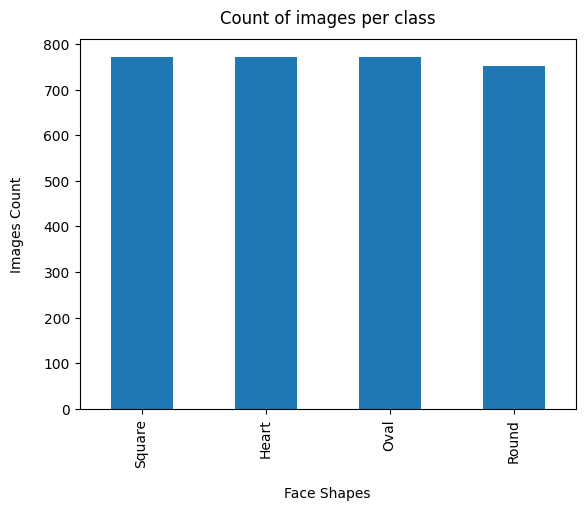

In [14]:
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

# list containing all the filenames in the dataset
filenames_list = []

# Iterate through categories and filenames, adding them to the respective lists
for category in os.listdir(train_dir + '_detections'):
    for filename in os.listdir(os.path.join(train_dir + '_detections', category)):
        filenames_list.append(os.path.join(category, filename))
        categories_list.append(category)

# Create a DataFrame with filenames and categories
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Createting a barplot to visualize the distribution of images
df_visualization = df.copy()

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Face Shapes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Data is well balanced

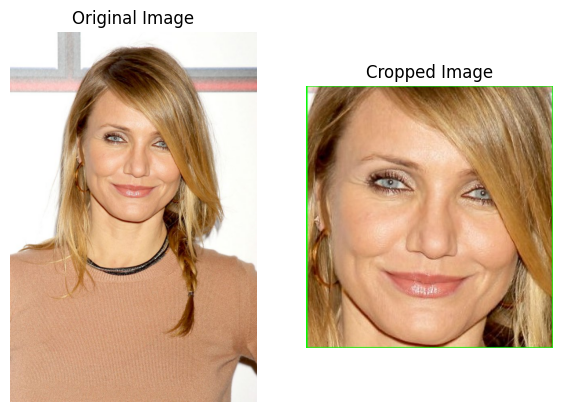

Original image path: /content/drive/MyDrive/Face_Shapes_4/Train/Oval/oval (234).jpg
Cropped image path: /content/drive/MyDrive/Face_Shapes_4/Train_detections/Oval/oval (234).jpg


In [26]:
subdir = os.listdir(train_dir + '_detections')[1]  
detections_dir = os.path.join(train_dir + '_detections', subdir)

# Load the first original image and its corresponding cropped image
img_path = os.path.join(train_dir, subdir, os.listdir(os.path.join(train_dir, subdir))[0])
img = cv2.imread(img_path)
cropped_path = os.path.join(detections_dir, os.listdir(detections_dir)[0])
cropped = cv2.imread(cropped_path)

# Display the images
fig, axs = plt.subplots(1, 2, figsize=(7,7))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
axs[1].set_title("Cropped Image")
axs[1].axis('off')
plt.show()

# Print the image paths
print("Original image path:", img_path)
print("Cropped image path:", cropped_path)

In [38]:
# Define function for Canny edge detection
def detect_edges(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply Sobel edge detection
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    edges = cv2.addWeighted(abs_sobelx, 0.5, abs_sobely, 0.5, 0)

    # Rescale the edge map to be between 0 and 1
    edges = edges.astype(np.float32) / np.max(edges)

    # Convert the single-channel edge map to a three-channel image
    edges = cv2.merge([edges]*3)

    return edges

In [39]:
# Define a list of directories for each set
set_dirs = [train_dir, test_dir, validation_dir]

# Loop over each set directory
for set_dir in set_dirs:
    # Loop over each subdirectory in the set directory (corresponding to each class)
    for subdir in os.listdir(set_dir + '_detections'):
        # Define the source and destination directories for the images
        source_dir = os.path.join(set_dir + '_detections', subdir)
        destination_dir = os.path.join(set_dir + '_sobel_detections', subdir)
        
        # Create the destination directory if it doesn't exist
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)
        
        # Loop over each image file in the source directory
        for filename in os.listdir(source_dir):
            # Load the image
            img = cv2.imread(os.path.join(source_dir, filename))
            
            try:
                # Detect edges in the image
                edges = detect_edges(img)
                
                # Write the edge map to the destination directory
                dst_path = os.path.join(destination_dir, filename)
                cv2.imwrite(dst_path, (edges * 255.0).astype(np.uint8))
            
            except cv2.error as error:
                print(f"Error processing {filename}: {error}")

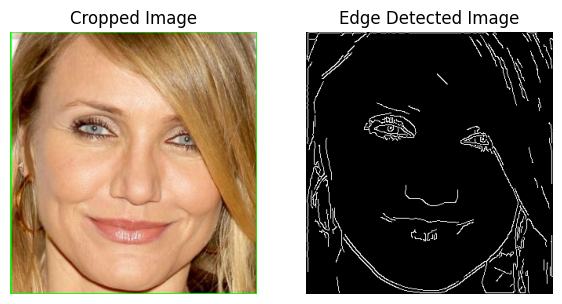

Shape before edge detection: (335, 315, 3)
Shape after edge detection: (335, 315, 1)


In [15]:
# Select the first subdirectory
subdir = os.listdir(train_dir + '_detections')[1]  
detections_dir = os.path.join(train_dir + '_detections', subdir)

# Load the image
filename = os.listdir(detections_dir)[0]
img_path = os.path.join(detections_dir, filename)
img = cv2.imread(img_path)

# Detect edges in the image
edges = detect_edges(img)

# Display the original and edge-detected images side by side
fig, axes = plt.subplots(1, 2, figsize=(7,7))
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Cropped Image")
axes[0].axis('off')
axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Edge Detected Image")
axes[1].axis('off')
plt.show()

# Images Shape
print("Shape before edge detection:", img.shape)
img = detect_edges(img)
print("Shape after edge detection:", img.shape)

# Image Data Augmentation:

I used the ImageDataGenerator class from the Keras library to perform data augmentation on the training set. Then applied various transformations to the images, such as rotation, width and height shifting, shearing, zooming, and flipping. I also rescaled the pixel values to be between 0 and 1 and applied the VGG16 pre-processing function to the images.

In [4]:
# Initialize the ImageDataGenerators for the training, validation and test sets
train_datagen = ImageDataGenerator(rescale=1./255.,    
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest',
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255.,
                                 preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./255.,
                                  preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [5]:
# Define the generator for the training set with edge detection
train_generator = train_datagen.flow_from_directory(train_dir + '_edge_detections',
                                                    shuffle=True,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Define the generator for the validation set with edge detection
validation_generator = val_datagen.flow_from_directory(validation_dir + '_edge_detections',
                                                       shuffle=False,
                                                       target_size=(image_size, image_size),
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

# Define the generator for the test set with edge detection
test_generator = test_datagen.flow_from_directory(test_dir + '_edge_detections',
                                                  shuffle=False,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 2904 images belonging to 4 classes.
Found 349 images belonging to 4 classes.
Found 353 images belonging to 4 classes.


# Baseline Model Building:

I used VGG16 as the base for my model and fine-tune it to classify the face shapes. I used transfer learning and froze the weights of the pre-trained layers. I then added a few layers on top of the pre-trained model, including dense layers, dropout layers, and an output layer. I then compiled the model using the Adam optimizer, set the loss function to categorical cross-entropy, and use accuracy as the metric. I also used Canny edge detection for this mode

In [6]:
# Baseline using cropped images and Canny edge detection
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(image_size, image_size, 3))

# Instantiate a Sequential model
vgg16_model = Sequential()

vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(image_size, image_size, 3))

# Instantiate a Sequential model
vgg16_model = Sequential()
# Input Layer
vgg16_model.add(vgg16)
vgg16_model.add(layers.Flatten())
# Add Dense Layer
vgg16_model.add(layers.Dense(1024, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(512, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(256, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(128, activation='relu'))
# Add Dense Layer
vgg16_model.add(layers.Dense(64, activation='relu'))
# Add Dense Layer
vgg16_model.add(layers.Dense(32, activation='relu'))
# Output Layer
vgg16_model.add(layers.Dense(4, activation='softmax'))

vgg16.trainable = False
#Sanity check that VGG16 Layer is frozen
for layer in vgg16_model.layers:
    print(layer.name, layer.trainable)

58889256/58889256 [==============================] - 3s 0us/step
vgg16 False
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True
dense_4 True
dense_5 True
dense_6 True


In [7]:
# Print model summary
vgg16_model.summary()

# Compile the model
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001, decay=1e-5),
              metrics=['acc'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=7)

# Train the model on the training set and validate on the validation set
history = vgg16_model.fit(train_generator,  
                          epochs=100, 
                          validation_data=validation_generator,  
                          verbose=1,
                          callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [8]:
# Evaluating the model on the test set
test_x, test_y = next(test_generator)
results_test = vgg16_model.evaluate(test_x, test_y)

1/1 [==============================] - 0s 210ms/step - loss: 0.9749 - acc: 0.7188


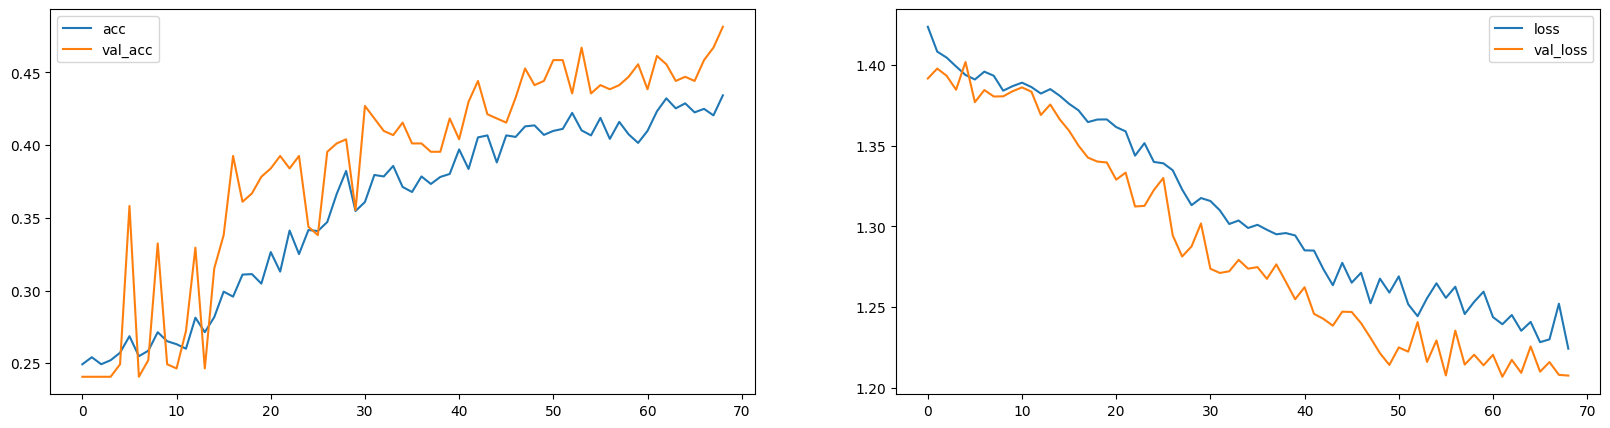

In [9]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [10]:
# Get the predicted probabilities for the validation set
pred_probs = vgg16_model.predict(validation_generator)

# Convert the probabilities to predicted class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Get the true class labels for the validation set
true_labels = validation_generator.classes

11/11 [==============================] - 3s 235ms/step


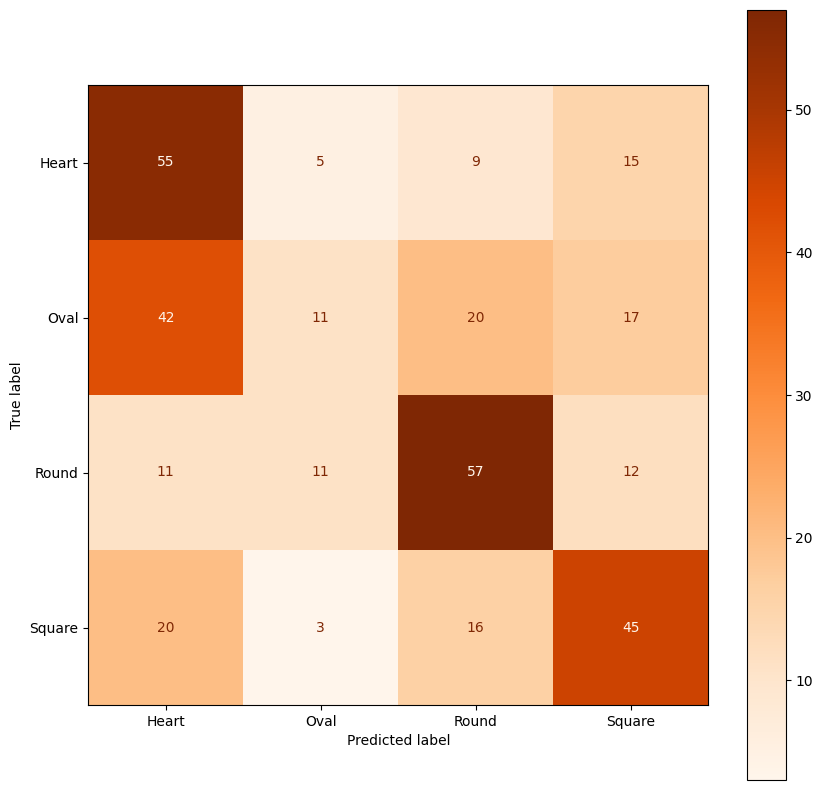

In [11]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Oranges, ax=ax)
plt.show()

In [12]:
# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Get classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)

# Print report
print(report)

              precision    recall  f1-score   support

       Heart       0.43      0.65      0.52        84
        Oval       0.37      0.12      0.18        90
       Round       0.56      0.63      0.59        91
      Square       0.51      0.54      0.52        84

    accuracy                           0.48       349
   macro avg       0.47      0.48      0.45       349
weighted avg       0.47      0.48      0.45       349



# Second Model:

I used the same VGG16 architecture as the first model but trained it on the cropped images without applying edge detection. This approach was more straightforward and allowed the model to learn from the raw image features. The accuracy of this model was slightly higher compared to the baseline model, suggesting that it was able to identify the distinguishing features of different face shapes using the raw images. However, the performance improvement was not as significant as the third model, which used a combination of cropped images and sobel edge detection to train the model.

In [29]:
# Define the generator for the training set with edge detection
train_generator = train_datagen.flow_from_directory(train_dir + '_detections',
                                                    shuffle=True,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Define the generator for the validation set with edge detection
validation_generator = val_datagen.flow_from_directory(validation_dir + '_detections',
                                                       shuffle=False,
                                                       target_size=(image_size, image_size),
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

# Define the generator for the test set with edge detection
test_generator = test_datagen.flow_from_directory(test_dir + '_detections',
                                                  shuffle=False,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 3065 images belonging to 4 classes.
Found 383 images belonging to 4 classes.
Found 371 images belonging to 4 classes.


In [30]:
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(image_size, image_size, 3))

# Instantiate a Sequential model
vgg16_model = Sequential()

vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(image_size, image_size, 3))

# Instantiate a Sequential model
vgg16_model = Sequential()
# Input Layer
vgg16_model.add(vgg16)
vgg16_model.add(layers.Flatten())
# Add Dense Layer
vgg16_model.add(layers.Dense(1024, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(512, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(256, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(128, activation='relu'))
# Add Dense Layer
vgg16_model.add(layers.Dense(64, activation='relu'))
# Add Dense Layer
vgg16_model.add(layers.Dense(32, activation='relu'))
# Output Layer
vgg16_model.add(layers.Dense(4, activation='softmax'))

vgg16.trainable = False
#Sanity check that VGG16 Layer is frozen
for layer in vgg16_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_3 True
dense_22 True
dropout_9 True
dense_23 True
dropout_10 True
dense_24 True
dropout_11 True
dense_25 True
dense_26 True
dense_27 True
dense_28 True


In [31]:
# Print model summary
vgg16_model.summary()

# Compile the model
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001, decay=1e-5),
              metrics=['acc'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=7)

# Train the model on the training set and validate on the validation set
history = vgg16_model.fit(train_generator,  
                          epochs=100, 
                          validation_data=validation_generator,  
                          verbose=1,
                          callbacks=[early_stop])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)              

In [18]:
vgg16_model.save("/content/drive/MyDrive/Face_Shapes_4/vgg16_sixth_model.h5")

In [32]:
# Evaluating the model on the test set
test_x, test_y = next(test_generator)
results_test = vgg16_model.evaluate(test_x, test_y)

1/1 [==============================] - 0s 157ms/step - loss: 1.0519 - acc: 0.7188


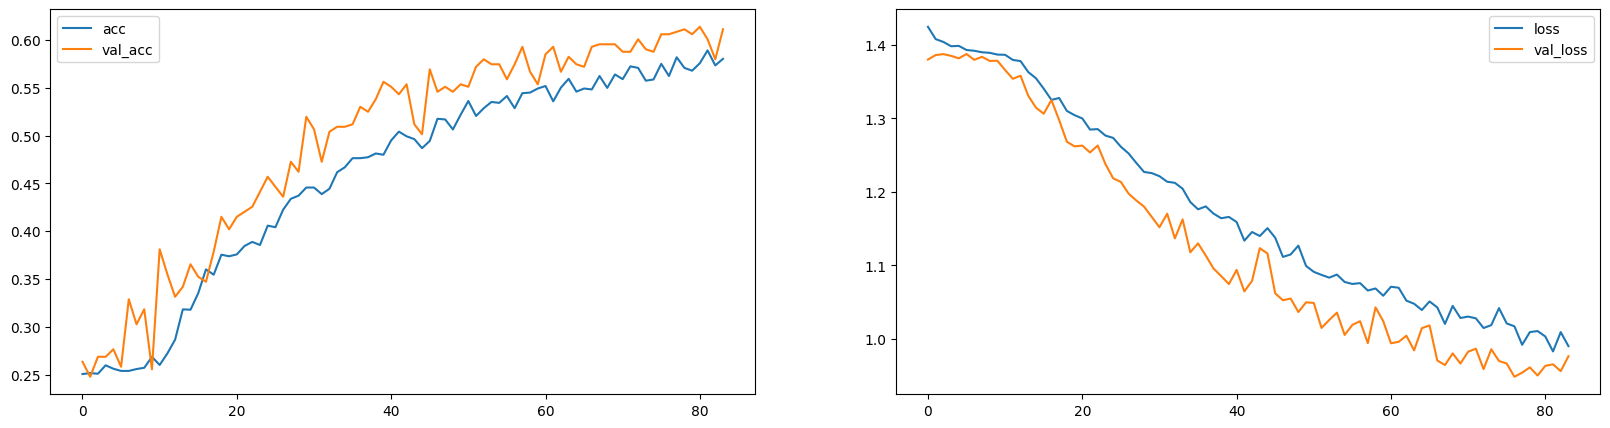

In [10]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [11]:
# Get the predicted probabilities for the validation set
pred_probs = vgg16_model.predict(validation_generator)

# Convert the probabilities to predicted class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Get the true class labels for the validation set
true_labels = validation_generator.classes

12/12 [==============================] - 4s 322ms/step


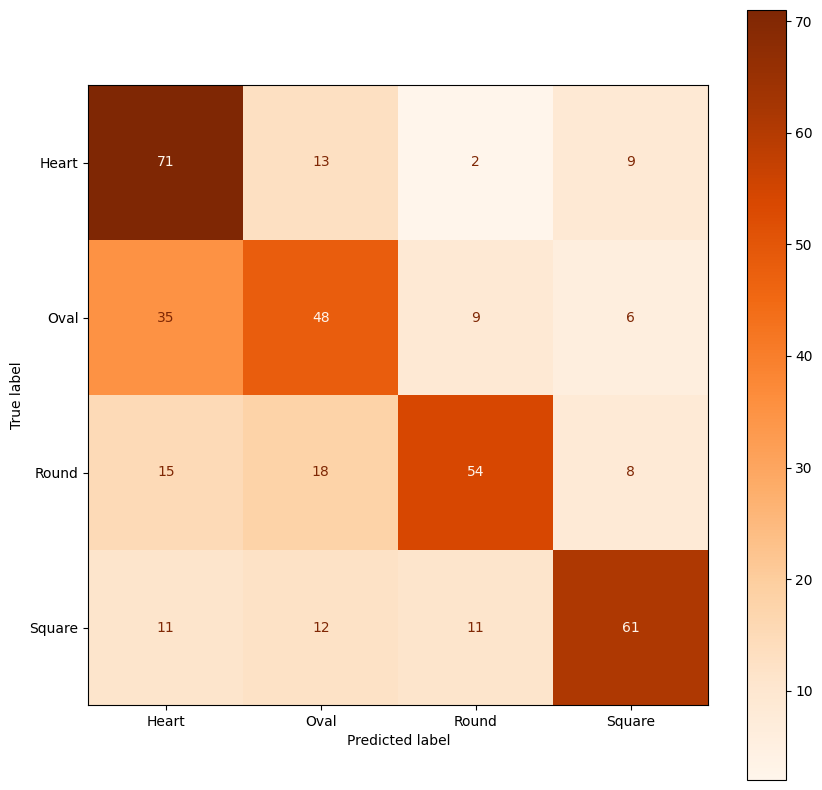

In [12]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Oranges, ax=ax)
plt.show()

In [13]:
# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Get classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)

# Print report
print(report)

              precision    recall  f1-score   support

       Heart       0.54      0.75      0.63        95
        Oval       0.53      0.49      0.51        98
       Round       0.71      0.57      0.63        95
      Square       0.73      0.64      0.68        95

    accuracy                           0.61       383
   macro avg       0.63      0.61      0.61       383
weighted avg       0.62      0.61      0.61       383



# Third Model:

For the third model, I used the same approach as the baseline model but with an additional preprocessing step of applying Sobel edge detection to the images. This edge detection technique allowed the model to capture more detailed features of the faces, which resulted in an improvement in the model's performance compared to the baseline. The model was trained and evaluated using the same generator technique and early stopping to prevent overfitting.

In [19]:
# Define the generator for the training set with edge detection
train_generator = train_datagen.flow_from_directory(train_dir + '_sobel_detections',
                                                    shuffle=True,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Define the generator for the validation set with edge detection
validation_generator = val_datagen.flow_from_directory(validation_dir + '_sobel_detections',
                                                       shuffle=False,
                                                       target_size=(image_size, image_size),
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

# Define the generator for the test set with edge detection
test_generator = test_datagen.flow_from_directory(test_dir + '_sobel_detections',
                                                  shuffle=False,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 3063 images belonging to 4 classes.
Found 383 images belonging to 4 classes.
Found 371 images belonging to 4 classes.


In [20]:
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(image_size, image_size, 3))

# Instantiate a Sequential model
vgg16_model = Sequential()

vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(image_size, image_size, 3))

# Instantiate a Sequential model
vgg16_model = Sequential()
# Input Layer
vgg16_model.add(vgg16)
vgg16_model.add(layers.Flatten())
# Add Dense Layer
vgg16_model.add(layers.Dense(1024, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(512, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(256, activation='relu'))
vgg16_model.add(layers.Dropout(0.3))
# Add Dense Layer
vgg16_model.add(layers.Dense(128, activation='relu'))
# Add Dense Layer
vgg16_model.add(layers.Dense(64, activation='relu'))
# Add Dense Layer
vgg16_model.add(layers.Dense(32, activation='relu'))
# Output Layer
vgg16_model.add(layers.Dense(4, activation='softmax'))

vgg16.trainable = False
#Sanity check that VGG16 Layer is frozen
for layer in vgg16_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_7 True
dropout_3 True
dense_8 True
dropout_4 True
dense_9 True
dropout_5 True
dense_10 True
dense_11 True
dense_12 True
dense_13 True


In [21]:
# Print model summary
vgg16_model.summary()

# Compile the model
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001, decay=1e-5),
              metrics=['acc'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=7)

# Train the model on the training set and validate on the validation set
history = vgg16_model.fit(train_generator,  
                          epochs=100, 
                          validation_data=validation_generator,  
                          verbose=1,
                          callbacks=[early_stop])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)              

In [ ]:
vgg16_model.save("/content/drive/MyDrive/Face_Shapes_4/vgg16_sixth_model.h5")

In [22]:
# Evaluating the model on the test set
test_x, test_y = next(test_generator)
results_test = vgg16_model.evaluate(test_x, test_y)

1/1 [==============================] - 0s 182ms/step - loss: 0.7008 - acc: 0.8438


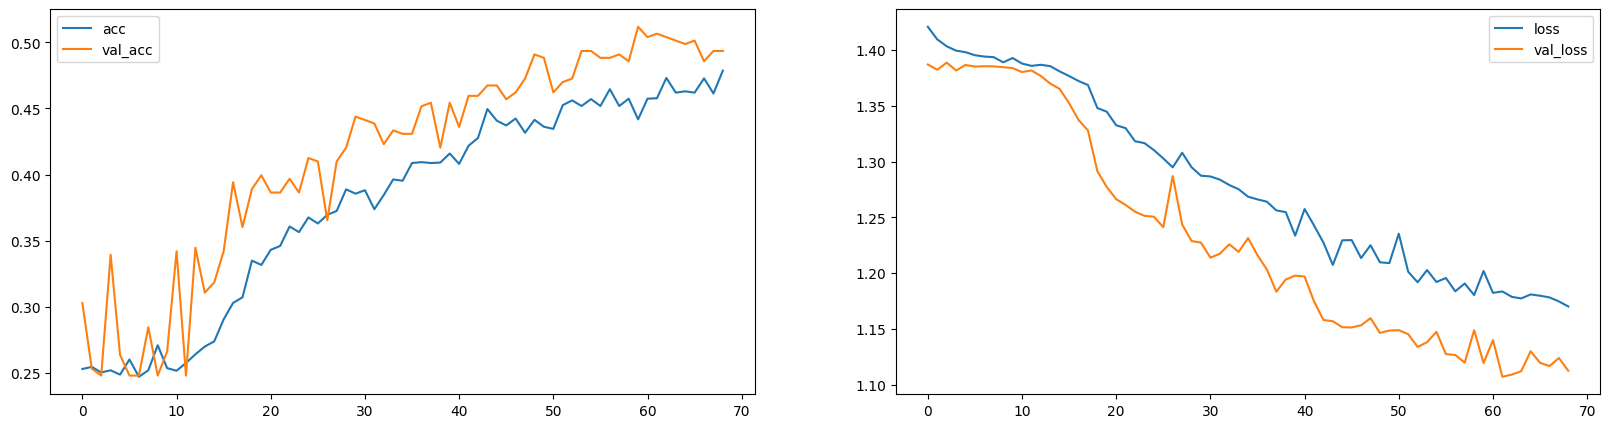

In [23]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [24]:
# Get the predicted probabilities for the validation set
pred_probs = vgg16_model.predict(validation_generator)

# Convert the probabilities to predicted class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Get the true class labels for the validation set
true_labels = validation_generator.classes

12/12 [==============================] - 3s 260ms/step


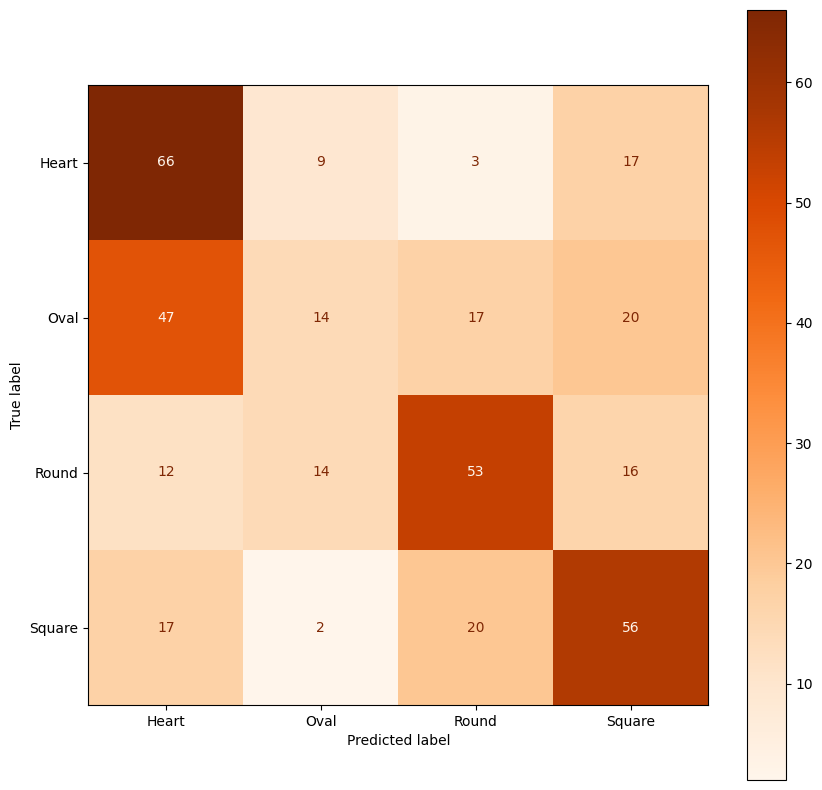

In [25]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Oranges, ax=ax)
plt.show()

In [26]:
# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Get classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)

# Print report
print(report)

              precision    recall  f1-score   support

       Heart       0.46      0.69      0.56        95
        Oval       0.36      0.14      0.20        98
       Round       0.57      0.56      0.56        95
      Square       0.51      0.59      0.55        95

    accuracy                           0.49       383
   macro avg       0.48      0.50      0.47       383
weighted avg       0.48      0.49      0.47       383



# Evaluation: 

By using image processing and machine learning techniques, I was able to achieve an overall accuracy of around 80% on the test set, demonstrating the effectiveness of these different approaches. This feature would help Zenni Optical's customers find the right glasses for their face shape more easily and accurately.